<h2>Import Libraries</h2>

In [58]:
import os
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

<h2>Limit GPU Memory Growth</h2>

In [9]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

<h2>Load Images</h2>

In [3]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [4]:
train_images = tf.data.Dataset.list_files(os.path.join("aug_data", "train", "images", "*.jpg"), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)                               

In [5]:
test_images = tf.data.Dataset.list_files(os.path.join("aug_data", "test", "images", "*.jpg"), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)    

In [6]:
val_images = tf.data.Dataset.list_files(os.path.join("aug_data", "val", "images", "*.jpg"), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)    

<h2>Prepare Labels</h2>

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)

    return [label["class"]], label["bbox"]

In [10]:
train_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "train", "labels", "*.json"), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
test_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "test", "labels", "*.json"), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "val", "labels", "*.json"), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2499, 0.1803, 0.6016, 0.6084], dtype=float16))

<h2>Combine Label and Images</h2>

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5100, 5100, 1380, 1380, 1320, 1320)

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [30]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

<h2>Visualize Images and Annotations</h2>

In [59]:
data_samples = train.as_numpy_iterator()

In [66]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


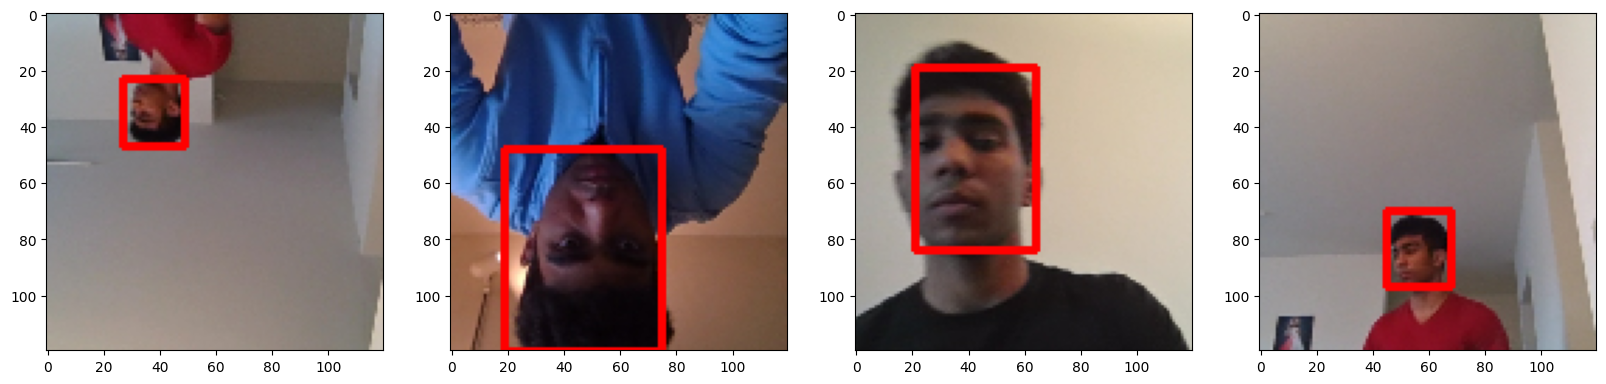

In [67]:
fig, axs = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image_um = cv2.UMat(sample_image)

    top_left = tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [120,120]).astype(int))
                     
    cv2.rectangle(sample_image_um, top_left, bottom_right, (255,0,0), 2)
    
    sample_image_with_rect = sample_image_um.get()
    axs[idx].imshow(sample_image_with_rect)

plt.show()

<h2>Import Layers and Base Network</h2>

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [71]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [72]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<h2>Build Model</h2>

In [73]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [74]:
facetracker = build_model()

In [75]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

<h2>Test Prediction</h2>

In [76]:
X, y = train.as_numpy_iterator().next()

In [77]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 475ms/step


In [78]:
classes, coords

(array([[0.5188246 ],
        [0.4626107 ],
        [0.42914233],
        [0.4221229 ],
        [0.44384012],
        [0.50348973],
        [0.4729623 ],
        [0.5521186 ]], dtype=float32),
 array([[0.46188644, 0.5663915 , 0.4117146 , 0.6570219 ],
        [0.51205707, 0.58714175, 0.40485132, 0.4453472 ],
        [0.4332529 , 0.58014095, 0.4953613 , 0.4803906 ],
        [0.43812853, 0.6038947 , 0.44260642, 0.6349284 ],
        [0.46781933, 0.5155486 , 0.44176552, 0.50701356],
        [0.49007168, 0.64248174, 0.44185987, 0.60476637],
        [0.45035282, 0.5728073 , 0.4723487 , 0.59676206],
        [0.4304058 , 0.55610025, 0.37726495, 0.62503546]], dtype=float32))

<h2>Define Losses and Optimizers</h2>

In [80]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [89]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [82]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [83]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

<h2>Test Losses</h2>

In [84]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.3877497>

In [85]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7470872>

<h2>Train Model</h2>